<a href="https://colab.research.google.com/github/cmnemoi/ProjetDataScienceLPSID/blob/main/src/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Data Science - Nettoyage des données
### Enzo Rizbeth et Charles-Meldhine MADI MNEMOI


Introduction du projet :

Ce projet s’inscrit dans le cadre de l’UE « projet tutoré » de l’université de Lille. Il consiste à sélectionner un jeu de données préalablement téléchargé, le nettoyer pour en garder que des données exploitables et enfin construire des modèles et en choisir le plus pertinent.

Pour cela nous alors utiliser différentes méthodes de régressions selon les modèles pour prédire le prix d’une course en taxi à New-York. Nous pensons que la méthode de régressions linéaire sera la méthode la plus pertinente et donc qu’elle fera partie du modèle choisi au final.  

Nous commencerons par un modèle très simple et continuerons sur des modèles de plus en plus complexes avant d’essayer de trouver le meilleur pour ce dataset. 


Objectif :

Dans ce notebook, nous allons analyser le dataset pour identifier les variables intéressantes pour la prédiction du prix de la course des taxis et retirer les valeurs aberrantes.

 Méthode d’extraction des données :

Nous avons téléchargé le fichier Excel provenant du site : https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page Les données sont celle du mois de Mai pour l’année 2020.


### Importation des packages et des données

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/cmnemoi/ProjetDataScienceLPSID/data_cleaning/data/data.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

In [ ]:
data.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-05-01 00:02:28,2020-05-01 00:18:07,1.0,0.0,1.0,N,234,256,1.0,12.2,3.0,0.5,2.4,0.0,0.3,18.4,2.5
1,1.0,2020-05-01 00:23:21,2020-05-01 00:26:01,2.0,0.4,1.0,N,264,264,1.0,4.0,0.5,0.5,0.5,0.0,0.3,5.8,0.0
2,1.0,2020-05-01 00:54:58,2020-05-01 00:57:11,1.0,0.3,1.0,N,264,264,2.0,3.5,0.5,0.5,0.0,0.0,0.3,4.8,0.0
3,1.0,2020-05-01 00:07:10,2020-05-01 00:12:46,1.0,1.7,1.0,N,107,229,2.0,7.0,3.0,0.5,0.0,0.0,0.3,10.8,2.5
4,1.0,2020-05-01 00:55:47,2020-05-01 01:01:54,0.0,0.9,1.0,N,237,262,1.0,6.0,3.0,0.5,1.2,0.0,0.3,11.0,2.5


On remarque notamment à l'aide du dictionnaire des variables que la variable à prédire `Total_amount` est la somme des variables suivantes : `fare_amount`, `extra`, `mta_tax`, `tip_amount`, `tolls_amount`, `improvement_surcharge` et `congestion_surcharge`. 
Les introduire dans notre modèle de prédiction n'est pas très pertinent, on les retire donc.

In [ ]:
data = data.drop(["fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge"], axis=1)

On remarque également les variables `PULocationID` et `DOLocationID`, qui sont les zones de début et de fin de course. 
Utilisons un dataset qui répertorie les libellés de ces zones pour les fusionner avec notre dataset :

In [ ]:
TLC_lookup_zones = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv")
TLC_lookup_zones["PULocationID"] = TLC_lookup_zones["LocationID"]
TLC_lookup_zones["DOLocationID"] = TLC_lookup_zones["LocationID"]
TLC_lookup_zones.head()

,LocationID,Borough,Zone,service_zone,PULocationID,DOLocationID
0,1,EWR,Newark Airport,EWR,1,1
1,2,Queens,Jamaica Bay,Boro Zone,2,2
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,3,3
3,4,Manhattan,Alphabet City,Yellow Zone,4,4
4,5,Staten Island,Arden Heights,Boro Zone,5,5


In [ ]:
#on fait des left join (pour éviter de retirer des valeurs dont le libellé de la zone est manquante)
data = pd.merge(data, TLC_lookup_zones[["PULocationID", "Zone"]], on="PULocationID", how="left")
data["PULocationLabel"] = data["Zone"]
data.head()
data = data.drop("Zone", axis=1)
data = pd.merge(data, TLC_lookup_zones[["DOLocationID", "Zone"]], on="DOLocationID", how="left")
data["DOLocationLabel"] = data["Zone"]
data = data.drop("Zone", axis=1)
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,PULocationLabel,DOLocationLabel
0,1.0,2020-05-01 00:02:28,2020-05-01 00:18:07,1.0,0.0,1.0,N,234,256,1.0,18.4,Union Sq,Williamsburg (South Side)
1,1.0,2020-05-01 00:23:21,2020-05-01 00:26:01,2.0,0.4,1.0,N,264,264,1.0,5.8,NV,NV
2,1.0,2020-05-01 00:54:58,2020-05-01 00:57:11,1.0,0.3,1.0,N,264,264,2.0,4.8,NV,NV
3,1.0,2020-05-01 00:07:10,2020-05-01 00:12:46,1.0,1.7,1.0,N,107,229,2.0,10.8,Gramercy,Sutton Place/Turtle Bay North
4,1.0,2020-05-01 00:55:47,2020-05-01 01:01:54,0.0,0.9,1.0,N,237,262,1.0,11.0,Upper East Side South,Yorkville East


In [ ]:
data.shape

(348371, 13)

### Retrait des valeurs manquantes

In [ ]:
data.isna().sum()

VendorID                 58891
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          58891
trip_distance                0
RatecodeID               58891
store_and_fwd_flag       58891
PULocationID                 0
DOLocationID                 0
payment_type             58891
total_amount                 0
PULocationLabel            619
DOLocationLabel           2269
dtype: int64

On observe des valeurs manquantes dans `VendorID`, `passenger_count`, `RatecodeID`, `store_and_fwd_flag` et `payment_type`. Ces individus ne représentant que 15% du dataset, on décide de les supprimer car il nous restera toujours assez de données pour travailler par la suite.

In [ ]:
data = data.dropna(subset=["VendorID", "passenger_count", "RatecodeID", "store_and_fwd_flag", "payment_type"])

In [ ]:
data.shape

(289480, 13)

### Identification des valeurs aberrantes

In [ ]:
for column in data.columns:
  try:
      print(f"Valeurs uniques dans {column} : {np.sort(data[column].unique())}")
  except Exception as e:
      continue

Valeurs uniques dans VendorID : [1. 2.]
Valeurs uniques dans tpep_pickup_datetime : ['2008-12-31 23:05:47' '2009-01-01 00:57:36' '2009-01-01 02:19:49' ...
 '2020-11-01 15:15:05' '2020-11-01 15:26:33' '2020-11-01 15:41:04']
Valeurs uniques dans tpep_dropoff_datetime : ['2008-12-31 23:33:33' '2009-01-01 01:05:48' '2009-01-01 02:23:35' ...
 '2020-11-01 15:23:18' '2020-11-01 15:39:04' '2020-11-01 15:57:02']
Valeurs uniques dans passenger_count : [0. 1. 2. 3. 4. 5. 6. 8. 9.]
Valeurs uniques dans trip_distance : [0.000000e+00 1.000000e-02 2.000000e-02 ... 2.380000e+02 3.051000e+02
 1.097355e+04]
Valeurs uniques dans RatecodeID : [ 1.  2.  3.  4.  5.  6. 99.]
Valeurs uniques dans store_and_fwd_flag : ['N' 'Y']
Valeurs uniques dans PULocationID : [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  28  29  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64

VendorID : ok
 
tpep_pickup_dateime : ok
 
tpep_dropoff_datetime : ok
 
passenger_count : les nombres de passagers à 8 et 9 semblent aberrantes, on les retire
 
trip_distance : à étudier en détail, valeurs à 0 à retirer
 
RateCodeID : vérifier combien il y a de 99 (valeurs absentes du dictionnaire). si négligeable, à supprimer
 
store_and_fwd_flag : RAS
 
PULocationID : RAS
 
DOLocationID : vérifier en déail

total_amount : passer les valeurs négatives en positif

On observe quelques valeurs intriguantes, voyons en détail :


Pour `tpep_pickup_datetime` et `tpep_dropoff_datetime`, on observe que certaines valeurs ne correspondent pas au mois de Mai 2020 comme convenu dans le périmètre de l'étude. On les retire, d'autant plus qu'elles ne reprédentent que 82 individus du dataset au maximum : nous aurons toujours assez de données pour continuer.

In [ ]:
data[~data["tpep_pickup_datetime"].str.contains("2020-05")].head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,PULocationLabel,DOLocationLabel
598,2.0,2020-04-30 17:55:31,2020-04-30 18:00:22,1.0,1.16,1.0,N,238,236,2.0,9.30,Upper West Side North,Upper East Side North
599,2.0,2020-04-30 18:18:23,2020-05-01 17:30:12,1.0,1.07,1.0,N,249,249,2.0,11.80,West Village,West Village
1065,2.0,2020-04-30 17:37:42,2020-04-30 17:48:31,1.0,2.77,1.0,N,230,263,1.0,16.56,Times Sq/Theatre District,Yorkville West
1066,2.0,2020-04-30 18:12:23,2020-05-01 17:29:16,1.0,5.32,1.0,N,142,231,2.0,19.80,Lincoln Square East,TriBeCa/Civic Center
35086,2.0,2009-01-01 02:19:49,2009-01-01 02:23:35,3.0,0.98,1.0,N,74,75,2.0,5.80,East Harlem North,East Harlem South


In [ ]:
print("Trajets hors mai 2020 : {}".format(data[~data["tpep_pickup_datetime"].str.contains("2020-05")].shape[0]))

Trajets hors mai 2020 : 23


In [ ]:
print("Trajets hors mai 2020 : {}".format(data[~data["tpep_dropoff_datetime"].str.contains("2020-05")].shape[0]))

Trajets hors mai 2020 : 69


In [ ]:
data = data[data["tpep_pickup_datetime"].str.contains("2020-05")]
data = data[data["tpep_dropoff_datetime"].str.contains("2020-05")]

Pour `passenger_count`, les valeurs 8 et 9 semblent aberrantes. En effet, difficile d'imaginer un taxi et une limousine avec 8 ou 9 passagers. D'après nos recherches, le maximum de passagers autorisés dans un taxi-limousine est de 6 personnes. 

Ces valeurs ne composant que deux individus de notre dataset, on les retire en gardant la variable.

In [ ]:
data[data["passenger_count"] >= 8]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,PULocationLabel,DOLocationLabel
166705,2.0,2020-05-20 06:42:42,2020-05-20 06:42:48,9.0,0.0,5.0,N,264,264,1.0,11.76,NV,NV
288378,2.0,2020-05-31 20:53:17,2020-05-31 20:53:19,8.0,0.0,5.0,N,116,116,1.0,11.00,Hamilton Heights,Hamilton Heights


In [ ]:
data = data[data["passenger_count"] < 8]

In [ ]:
data[data["passenger_count"] < 1]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,PULocationLabel,DOLocationLabel
4,1.0,2020-05-01 00:55:47,2020-05-01 01:01:54,0.0,0.9,1.0,N,237,262,1.0,11.00,Upper East Side South,Yorkville East
5,1.0,2020-05-01 00:38:37,2020-05-01 01:03:08,0.0,12.0,1.0,N,140,28,1.0,39.30,Lenox Hill East,Briarwood/Jamaica Hills
74,1.0,2020-05-01 00:02:48,2020-05-01 00:07:05,0.0,1.2,1.0,N,137,141,2.0,9.30,Kips Bay,Lenox Hill West
75,1.0,2020-05-01 00:20:58,2020-05-01 00:24:21,0.0,0.6,1.0,N,141,237,1.0,10.35,Lenox Hill West,Upper East Side South
217,2.0,2020-05-01 03:13:06,2020-05-01 03:13:12,0.0,0.0,5.0,N,41,41,1.0,28.99,Central Harlem,Central Harlem
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289283,1.0,2020-05-31 23:24:44,2020-05-31 23:42:29,0.0,3.5,1.0,N,264,66,3.0,18.30,NV,DUMBO/Vinegar Hill
289427,1.0,2020-05-31 23:00:43,2020-05-31 23:17:42,0.0,6.3,1.0,N,162,244,2.0,23.80,Midtown East,Washington Heights South
289428,1.0,2020-05-31 23:18:01,2020-05-31 23:25:24,0.0,1.4,1.0,N,170,186,1.0,13.56,Murray Hill,Penn Station/Madison Sq West
289429,1.0,2020-05-31 23:28:44,2020-05-31 23:42:22,0.0,4.4,1.0,N,48,41,1.0,21.95,Clinton East,Central Harlem


On observe également 9605 lignes avec 0 passagers. 

Elles représentent 3% de notre dataset, on peut donc les supprimer en conservant la variable.

In [ ]:
data = data[data["passenger_count"] > 0]

Pour `RatecodeID`, on observe la valeur 99 qui n'est pas renseignée dans le dictionnaire des variables :

In [ ]:
data[data["RatecodeID"] == 99].head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,PULocationLabel,DOLocationLabel
1103,2.0,2020-05-01 07:59:33,2020-05-01 08:10:08,1.0,0.0,99.0,N,193,146,1.0,20.23,Queensbridge/Ravenswood,Long Island City/Queens Plaza
5312,2.0,2020-05-01 14:28:38,2020-05-01 14:32:06,1.0,0.0,99.0,N,132,132,2.0,3.80,JFK Airport,JFK Airport
10534,2.0,2020-05-02 07:33:40,2020-05-02 07:39:07,1.0,0.0,99.0,N,137,198,2.0,23.14,Kips Bay,Ridgewood
30597,1.0,2020-05-04 20:08:54,2020-05-04 20:09:47,1.0,0.0,99.0,N,142,142,3.0,429562.25,Lincoln Square East,Lincoln Square East
69477,2.0,2020-05-09 02:26:49,2020-05-09 02:50:27,1.0,0.0,99.0,N,65,188,1.0,14.05,Downtown Brooklyn/MetroTech,Prospect-Lefferts Gardens


In [ ]:
data[data["RatecodeID"] == 99].size

234

Il n'y a que 198 individus qui possèdent cette modalité, on les retire donc en conservant la variable.

In [ ]:
data = data[data["RatecodeID"] != 99]

Examinons `trip_distance` :


In [ ]:
data["trip_distance"].describe()

count    279784.000000
mean          2.737236
std          21.038054
min           0.000000
25%           0.950000
50%           1.700000
75%           3.100000
max       10973.550000
Name: trip_distance, dtype: float64

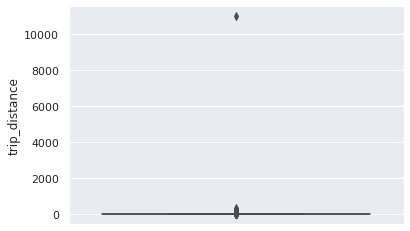

In [ ]:
sns.boxplot(y=data["trip_distance"])

On observe d'une part des trajets de 0 miles, ce qui est impossible à priori.

On observe d'autre part que le trajet maximum enregistré est de 10 973 miles. 
Or les taxis de TLC ne peuvent aller qu'au Connecticut, New Jersey et dans l'Etat de New York au maximum d'après la [FAQ](https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page).

Si on approxie cette surface à un cercle, sa superficie est d'environ 38 334,697 km². On obtient alors le diamètre du cercle par la formule :


$Superficie = \frac{\pi \times Diamètre^{2}}{2} \Leftrightarrow Diamètre = \sqrt{\frac{2 \times Superficie}{\pi}}$

In [ ]:
area = 22608+14371+141.297+1214.4 #somme des superficies des états de la zone d'action de TLC en km²
diameter_in_km = math.sqrt(2*area/math.pi)
diameter_in_miles = diameter_in_km * 1.60934 #on convertit en miles
print(f"Diamètre de la zone d'action (distance maximale parcourable) : {diameter_in_miles:.2f} miles")

Diamètre de la zone d'action (distance maximale parcourable) : 251.41 miles


On retire donc de notre dataset toute valeur physiquement impossible : celles nulles et supérieures à 251,41 miles :

In [ ]:
data = data[data["trip_distance"] > 0]
data = data[data["trip_distance"] < diameter_in_miles]

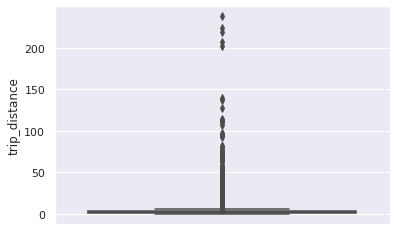

In [ ]:
sns.boxplot(y=data["trip_distance"])

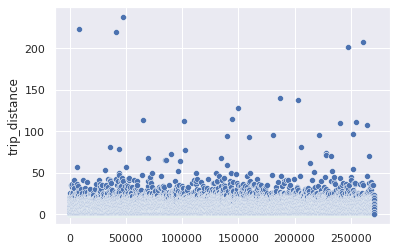

In [ ]:
sns.scatterplot(x=range(data["trip_distance"].size), y=data["trip_distance"])

On observe encore beaucoup de points supérieurs à 75% des autres sur la boite à moustache mais on choisit de les garder pour l'instant. 
 
On observera l'effet de la standardisation des données lors de la phase de
modélisation et l'effet de leur absence ou non sur l'amélioration de nos modèles.

Observons la distribution de `total_amount` :

In [ ]:
data["total_amount"].describe()

count    270937.000000
mean         15.794469
std          12.353868
min        -244.300000
25%           9.800000
50%          12.800000
75%          17.800000
max         846.290000
Name: total_amount, dtype: float64

On observe des valeurs négatives, ce qui est impossible. On les retire donc :

In [ ]:
data = data[data["total_amount"] > 0]

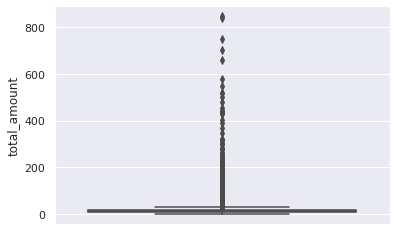

In [ ]:
sns.boxplot(y=data["total_amount"])

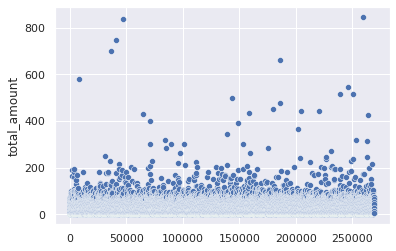

In [ ]:
sns.scatterplot(x=range(data["total_amount"].size), y=data["total_amount"])

De même on observe encore beaucoup de valeurs atypiques que l'on garde en attente de standardisation durant la phase de modélisation.


In [ ]:
data.shape

(269595, 13)

On a désormais un dataset composé de 269 565 individus purgé des valeurs aberrantes, on peut passer à la phase d'analyse exploratoire.

On exporte le dataset nettoyé :

In [ ]:
data.to_csv("cleaned_dataset.csv", index=False)